In [1]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.tree import export_graphviz
import pickle
import numpy as np
import matplotlib.pyplot as plt


# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre,
# fields : id feature -> nom
[data, id2titles, fields] = pickle.load(open("imdb_extrait.pkl", "rb"))
# la derniere colonne est le vote
datax = data[:, :32]
datay = np.array([1 if x[33] > 6.5 else -1 for x in data])

dt = DTree()
dt.max_depth = 3  # on fixe la taille max de l'arbre a 5
dt.min_samples_split = 2  # nombre minimum d'exemples pour spliter un noeud
dt.fit(datax, datay)
dt.predict(datax[:5, :])
print(dt.score(datax, datay))

id2genre = [x[1] for x in sorted(fields . items())[: -2]]
# utiliser http :// www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/Graphviz
# export_graphviz(dt, out_file="/tmp/tree.dot", feature_names=id2genre)
# ou avec pydotplus
# tdot = export_graphviz(dt, feature_names=id2genre)
# pydotplus.graph_from_dot_data(tdot).write_png("tree.png")

0.7183344233703945


En augmentant la profondeur max, il y a de plus en plus de sample uniquement d'un coté de l'arbre. Normalement on overfit l'arbre à chaque exemple 

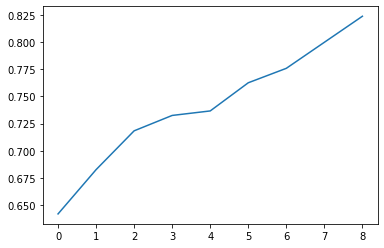

In [2]:
score_list = []
for i in range(1, 10):
    dt = DTree()
    dt.max_depth = i  # on fixe la taille max de l'arbre a 5
    dt.min_samples_split = 2  # nombre minimum d'exemples pour spliter un noeud
    dt.fit(datax, datay)
    dt.predict(datax[:5, :])
    score_list.append(dt.score(datax, datay))
plt.plot(score_list)

Il faut test sur un set de test pour constater de l'overfitting.

Les scores sont croissant

# Sur et sous apprentissage

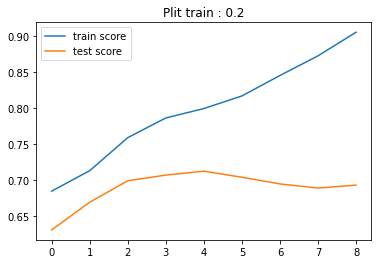

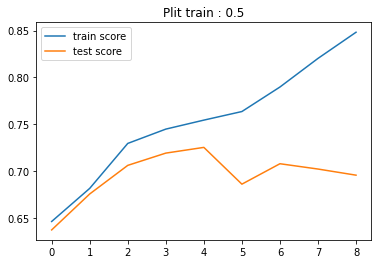

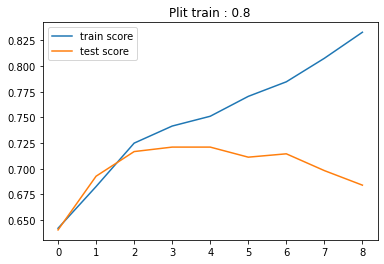

In [12]:
for train_size in [0.2, 0.5, 0.8]:
    score_list_train = []
    score_list_test = []
    # train test split
    split = int(len(datax)*train_size)
    datax_train = datax[:split]
    datay_train = datay[:split]
    datax_test = datax[split:]
    datay_test = datay[split:]
    # learning
    for i in range(1, 10):
        dt = DTree()
        dt.max_depth = i
        dt.min_samples_split = 2
        dt.fit(datax_train, datay_train)
        score_list_train.append(dt.score(datax_train, datay_train))
        score_list_test.append(dt.score(datax_test, datay_test))
    plt.plot(score_list_train, label='train score')
    plt.plot(score_list_test, label='test score')
    plt.legend()
    plt.gca().set_title(f"Plit train : {train_size}")
    plt.show()

1.8

On peut voir une divergence dès qu'on dépasse une profondeur de 5. C'est à partir de ce moment là qu'on passe sur de l'overfiting.

La taille optimal serait 4 ? Même avant pour plus de généralisation, quand on regarde le plateau sur un train de taille 0.8.


L'erreur diminue plus rapidement lorsque le train est petit. Quand on a beaucoup d'exemple d'apprentissage, la distance entre la précision sur le train et la précision sur le test est moins forte. La divergence entre les deux courbes est plus lente.

1.9 

Il y a un deuxième paramètre à optimiser, le nombre min d'exemple par noeud. On peut aussi optimiser d'autre hyperparam tel que le gain d'entropie minimal.

# Validation croisée

## Avec Sk-learn

In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np
for i in range(1, 10):
    dt = DTree()
    dt.max_depth = i
    dt.min_samples_split = 2
    scores_list = cross_val_score(dt, datax, datay, cv=5)
    print(f"Max_depth : {i}, Mean : {np.mean(scores_list)}, Std : {np.std(scores_list)}")

Max_depth : 1, Mean : 0.6418112961893834, Std : 0.024537038449211176
Max_depth : 2, Mean : 0.6819255267840809, Std : 0.021566410074660182
Max_depth : 3, Mean : 0.7069961487563643, Std : 0.008406585969767856
Max_depth : 4, Mean : 0.7141918684352453, Std : 0.007821565348296209
Max_depth : 5, Mean : 0.7202966004043687, Std : 0.010229827869529706
Max_depth : 6, Mean : 0.7220397573787786, Std : 0.010914202832552556
Max_depth : 7, Mean : 0.7231314578418305, Std : 0.003833665921499187
Max_depth : 8, Mean : 0.7159357381629496, Std : 0.013772386865725607
Max_depth : 9, Mean : 0.7104862640560891, Std : 0.012860894273683133


Ici la profondeur de 7 semble pas mal, de plus c'est elle qui a la plus faible variance

## Presque à la main

In [37]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validation(dt, X, y, k_fold):
    kf = KFold(n_splits=k_fold)
    for train, test in kf.split(X, y):
        dt_copy = clone(dt)
        dt_copy.fit(X[train], y[train])
        score_list_test.append(dt_copy.score(X[test], y[test]))
    return score_list_test

In [38]:
for i in range(1, 10):
    dt = DTree()
    dt.max_depth = i
    dt.min_samples_split = 2
    scores_list = cross_validation(dt, datax, datay, 5)
    print(f"Max_depth : {i}, Mean : {np.mean(scores_list)}, Std : {np.std(scores_list)}")

Max_depth : 1, Mean : 0.6978117104722023, Std : 0.03223486390130406
Max_depth : 2, Mean : 0.6965706394941352, Std : 0.031733526130335594
Max_depth : 3, Mean : 0.6976264488905789, Std : 0.030810444353203115
Max_depth : 4, Mean : 0.698878556534596, Std : 0.030215192085195186
Max_depth : 5, Mean : 0.7004688112240419, Std : 0.029915247423108263
Max_depth : 6, Mean : 0.7016360261944755, Std : 0.029414017120435912
Max_depth : 7, Mean : 0.7029048327262784, Std : 0.029095165467667806
Max_depth : 8, Mean : 0.7033078855132185, Std : 0.028450481234591905
Max_depth : 9, Mean : 0.7033397435532843, Std : 0.027982203738375493
